In [27]:
import re
import string
from unicodedata import normalize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import gensim
import pandas as pd
import spacy
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
from nltk import word_tokenize
from nltk.corpus import stopwords

In [28]:
nlp = spacy.load('es_core_news_sm')

In [29]:
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop
esp_stop.remove('estado')

In [30]:
def lemmatizer(text):
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc if word.lemma_ not in esp_stop])

### Apertura archivo y preprocesamiento

In [31]:
with open("data/nc_ch_articles.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_art = data.split("--articulo--")

In [32]:
df_art = pd.DataFrame(list_art, columns = ["article"])

In [33]:
def preprocess(df, column):
  articles = df

  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].str.strip()
  articles[column] = articles[column].str.replace('\n', ' ')
  articles[column] = articles[column].str.replace('nº', ' ')
  articles[column] = articles[column].str.translate(str.maketrans(' ', ' ', string.punctuation))
  articles[column] = articles[column].apply(lambda x: " ".join(x.split()))
  articles[column] = articles[column].apply(lambda x: re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize("NFD", x), 0, re.I))

  articles = articles[[len(str(x).split()) > 2 for x in articles[column]]]
  return articles.reset_index(drop=True)

In [34]:
df_art_p = preprocess(df_art, "article")

In [35]:
corpus = [word_tokenize(lemmatizer(i)) for i in df_art_p["article"]]

In [36]:
dict_corpus = corpora.Dictionary(corpus)

dtm_gensim = [dict_corpus.doc2bow(i) for i in corpus]
dtm_gensim_tfidf = models.TfidfModel(dtm_gensim)[dtm_gensim]

In [37]:
lda_gensim = gensim.models.ldamodel.LdaModel
ldamodel_gensim = lda_gensim(
    dtm_gensim_tfidf,
    num_topics = 25,
    passes = 1000,
    id2word = dict_corpus,
    random_state = 0,
    eval_every = None,
    alpha = 'auto'
)

In [38]:
ldamodel_gensim.print_topics(
    num_words = 15,
    num_topics = 49
)

[(0,
  '0.008*"elegido" + 0.005*"tutela" + 0.004*"proporcionalidad" + 0.004*"asumirar" + 0.004*"plurinacional" + 0.004*"par" + 0.003*"habitar" + 0.003*"ambiente" + 0.003*"clase" + 0.003*"habitir" + 0.003*"caracteristica" + 0.003*"sano" + 0.003*"equilibrado" + 0.003*"afirmativo" + 0.003*"tropa"'),
 (1,
  '0.011*"promocion" + 0.010*"comision" + 0.009*"distribucion" + 0.008*"diversidad" + 0.008*"crear" + 0.007*"solicitar" + 0.007*"determinacion" + 0.007*"relacion" + 0.006*"partir" + 0.006*"particular" + 0.006*"reeleccion" + 0.005*"terna" + 0.005*"indigén" + 0.005*"lengua" + 0.005*"consulta"'),
 (2,
  '0.004*"defensorio" + 0.003*"niñez" + 0.003*"asegurado" + 0.003*"negociacion" + 0.003*"expropiado" + 0.003*"ecologicar" + 0.003*"contralorio" + 0.003*"conciencia" + 0.002*"afirmativo" + 0.002*"prevalecerar" + 0.002*"hidrologico" + 0.002*"fases" + 0.002*"vecino" + 0.002*"ubicado" + 0.002*"limitrof"'),
 (3,
  '0.009*"calificador" + 0.007*"desempeñar" + 0.006*"interés" + 0.005*"provincia" + 0.

In [39]:
df_topic_term = pd.DataFrame(
    ldamodel_gensim.get_topics(),
    columns = ldamodel_gensim.id2word.values(),
    index = [f'topic{i}' for i in range(ldamodel_gensim.num_topics)]
)

In [40]:
df_topic_term.sort_values(by = df_topic_term.columns.values.tolist(), ascending = False)

,actividad,asegurar,bien,chile,colectivo,condición,constituir,cultural,deber,democracia,...,quincuagesima,quincuagesimo,rebajar,recaer,reclamacion,reconstruccion,rever,segunir,tipificado,transitarar
topic23,0.003134,0.000042,0.000042,0.003912,0.000042,0.000042,0.001352,0.000042,0.000042,0.000042,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042
topic10,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,...,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285,0.000285
topic13,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,...,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276,0.000276
topic4,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,...,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271,0.000271
topic22,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,...,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270
topic8,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,...,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270
topic11,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,...,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268
topic18,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,...,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268,0.000268
topic2,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,...,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267
topic17,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,...,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267


In [41]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda = CoherenceModel(model=ldamodel_gensim, texts=corpus, dictionary=dict_corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim.log_perplexity(dtm_gensim_tfidf))  # a measure of how good the model is. lower the better.


Coherence Score:  0.4886493222079435

Perplexity:  -11.966812569582608


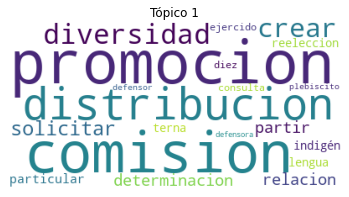

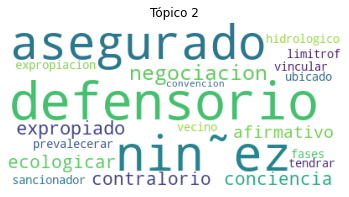

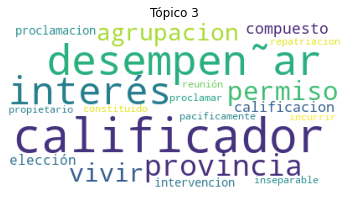

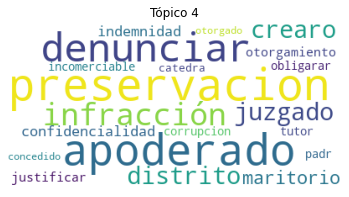

In [42]:
for i in range(1, 5):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim.show_topic(i, 20)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

In [43]:
with open("data/nc_ch_chapters.txt", "r") as file:
    data = file.read()
    data = data.replace("\n", " ")
    data = re.sub("\d+", "", data)
    data = data.lower()
    list_chapters = data.split("--capitulo--")

In [44]:
df_charperts = pd.DataFrame(list_chapters, columns=["chapter"])

In [45]:
df_charperts_p = preprocess(df_charperts, "chapter")

In [46]:
corpus_chapters = [word_tokenize(lemmatizer(i)) for i in df_charperts_p["chapter"]]

In [47]:
dict_corpus_chapter = corpora.Dictionary(corpus_chapters)

dtm_gensim_chapters = [dict_corpus_chapter.doc2bow(i) for i in corpus_chapters]
dtm_gensim_tfidf_chapters = models.TfidfModel(dtm_gensim_chapters)[dtm_gensim_chapters]

In [48]:
lda_gensim_chapters = gensim.models.ldamodel.LdaModel
ldamodel_gensim_chapters = lda_gensim(
    dtm_gensim_tfidf_chapters,
    num_topics=8,
    passes=1000,
    id2word=dict_corpus_chapter,
    random_state=0,
    eval_every=None,
    alpha='auto'
)

In [49]:
lda_gensim_chapters.print_topics(
    num_words=15,
    num_topics=8
)

TypeError: print_topics() missing 1 required positional argument: 'self'

In [ ]:
df_topic_term_chapters = pd.DataFrame(
    ldamodel_gensim_chapters.get_topics(),
    columns=ldamodel_gensim_chapters.id2word.values(),
    index=[f'topic{i}' for i in range(ldamodel_gensim_chapters.num_topics)]
)

df_topic_term_chapters.sort_values(by=df_topic_term_chapters.columns.values.tolist(), ascending=False)

In [ ]:
# Compute Coherence Score
'''
La Métrica de Coherencia nos da una idea de cómo de coherente es un modelo en cuanto a la distribución de sus topics: cuanto más distintas sean las palabras de los topics entre sí, menos relacionados estarán los topics y más coherente será el modelo.
'''
coherence_model_lda_chapters = CoherenceModel(model=ldamodel_gensim_chapters, texts=corpus_chapters, dictionary=dict_corpus_chapter, coherence='c_v')
coherence_lda_chapters = coherence_model_lda_chapters.get_coherence()
print('\nCoherence Score: ', coherence_lda_chapters)

# Compute Perplexity
'''
Por otro lado, la Perplejidad es una medida de cuánto se sorprende el modelo cuando se le añade datos que no había visto antes.
'''
print('\nPerplexity: ', ldamodel_gensim_chapters.log_perplexity(dtm_gensim_tfidf_chapters))  # a measure of how good the model is. lower the better.

In [ ]:
for i in range(0, 8):
    plt.figure()
    plt.imshow(
        WordCloud(
            background_color = 'white',
            prefer_horizontal = 1.0
        ).fit_words(dict(ldamodel_gensim_chapters.show_topic(i, 10)))
    )
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()